## Re-implementation of Domijan's (2015) brightness perception model

This jupyter notebook tries to provide a deeper understanding of the brightness perception model that was proposed by Domijan (2015) in "A Neurocomputational account of the role of contour facilitation
in brightness perception".

The filling-in model focusses on the relevance of contour processing for brightness perception.
It implements the idea that neural responses to low-contrast contours are enhanced in the presence of collinear or parallel high-contrast contours in the surround (=contour facilitation).
Under certain circumstances, this leads to a suppression of these enhanced contours in the final Edge Map, which will result in brightness assimilation in the Filling-in Layer.
The interaction between brightness assimilation and the local contrast information is one of the most central aspects of this model, and will enable it to account for all the proposed brightness illusions.


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from scipy.signal import fftconvolve
import scipy.ndimage as ndimage
from IPython.display import HTML

from functions import generate_input, save_video

## Helper functions:
Throughout the code, we need the following helper functions:
1. Threshold-linear function that eliminates negative values (`f_fun`)
2. Heaviside step function that converts all values to 0 or 1 (`h_fun`)
3. "Sigmoid function" that eliminates negative values and values higher than S_max (`s_fun`)

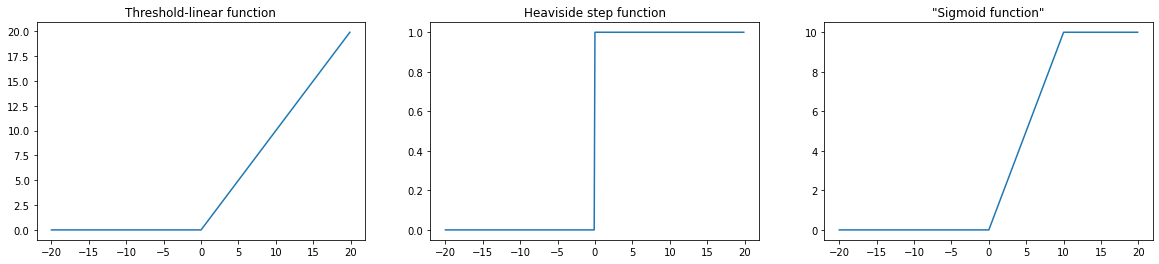

In [2]:
# Threshold-linear function:
def f_fun(x):
    y = x * (x > 0).astype(np.float)
    return np.abs(y)

# Heaviside step function:
def h_fun(x):
    y = (x > 0).astype(np.float)
    return np.abs(y)

# "Sigmoid function" with S_max controlling the upper saturation point:
def s_fun(S_max, x):
    y = (x < S_max) * (x * (x > 0).astype(np.float)) + S_max*(x >= S_max)
    return np.abs(y)

# For visualization purposes:
x_helper = np.arange(-20, 20, 0.1)
S_max = 10.

# Plotting:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(x_helper, f_fun(x_helper))
plt.title('Threshold-linear function')
plt.subplot(132)
plt.plot(x_helper, h_fun(x_helper))
plt.title('Heaviside step function')
plt.subplot(133)
plt.plot(x_helper, s_fun(S_max, x_helper))
plt.title('"Sigmoid function"')
plt.show()

## Create input image
We can create different input stimuli with the `generate_input` function. All stimuli are comprised of three intensity values: 1 indicating black, 5 indicating gray, and 9 indicating white.

A non-exhaustive list of possible input stimuli with corresponding numbers. For more information see `brightness_model_functions.py`:
1. Dungeon illusion
2. Cube illusion
3. Grating illusion
4. Ring pattern
5. Bullseye illusion
6. Simultaneous brightness contrast
7. White illusion
8. Benary's cross
9. Todorovic's illusion
10. Contrast-contrast effect
11. Checkerboard contrast
12. Extended version of checkerboard contrast

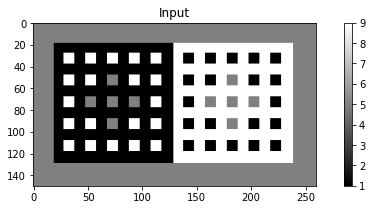

In [3]:
# Create input stimulus
input_raw = generate_input(1)

# Add mid-gray surround to the image
back_size = 20
M, N = input_raw.shape
input_image = 5 * np.ones([M+2*back_size, N+2*back_size])
input_image[back_size-1:M+back_size-1, back_size-1:N+back_size-1] = input_raw

# Plotting
plt.figure(figsize=(10,3))
plt.imshow(input_image, cmap='gray')
plt.title('Input')
plt.colorbar()
plt.show()

## Retinal processing

### 1. The CONTRAST pathways
Nodes in the Contrast Pathway compute the luminance ratios between the two sides of a luminance border by using shunting or divisive inhibition.
The computation of this ratio is implemented by nodes that have a BALANCED center-surround receptive field that simulates the properties of retinal ganglion cells and neurons in the LGN.
These cells respond strongly to sharp luminance borders but their response is attenuated on more shallow luminance gradients.

We will differentiate the Contrast Pathway into two further pathways: (1) the ON Contrast Pathway, and (2) the OFF Contrast Pathway.
When considering a bright-dark luminance border, the nodes in the ON Contrast Pathway respond most strongly to the bright side of the border, while the nodes in the OFF Contrast Pathway respond most strongly to the dark side of this border.

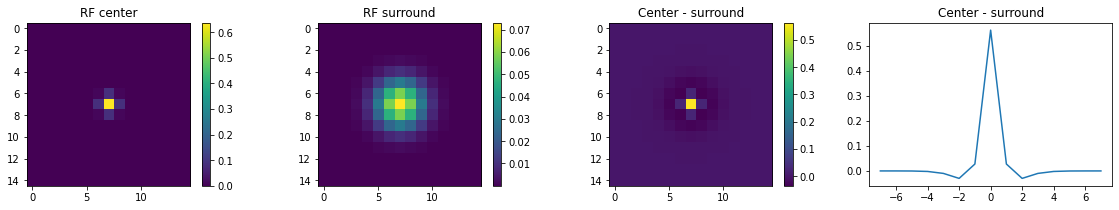

Sum of all kernel values:  -0.005


In [4]:
# Set size of the RF:
RF_size = 15
x_retina = np.arange(-int(RF_size/2), int(RF_size/2)+1, 1)
xx_retina, yy_retina = np.meshgrid(x_retina, x_retina)

# The RF will be modelled as a balanced difference-of-Gaussians
# filter:
# Parameters for the filter:
C1 = 1.        # Peak response of the center Gaussian
S1 = 1.03361   # Peak response of the surround Gaussian
Sigma_c = 0.5  # Width of center Gaussian
Sigma_s = 1.5  # Width of surround Gaussian

# Create balanced center and surround RFs:
Gauss_con_c = C1 * np.exp(-(xx_retina**2 + yy_retina**2) / (2*Sigma_c**2)) / (2*np.pi*Sigma_c**2)
Gauss_con_s = S1 * np.exp(-(xx_retina**2 + yy_retina**2) / (2*Sigma_s**2)) / (2*np.pi*Sigma_s**2)

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(141)
plt.imshow(Gauss_con_c)
plt.title('RF center')
plt.colorbar()
plt.subplot(142)
plt.imshow(Gauss_con_s)
plt.title('RF surround')
plt.colorbar()
plt.subplot(143)
plt.imshow(Gauss_con_c - Gauss_con_s)
plt.title('Center - surround')
plt.colorbar()
plt.subplot(144)
plt.plot(x_retina, (Gauss_con_c - Gauss_con_s)[int(RF_size/2),:])
plt.title('Center - surround')
plt.show()

# Summing the kernel up shows that it is "balanced"
print('Sum of all kernel values: ', np.round((Gauss_con_c - Gauss_con_s).sum(), 3))

Next, we filter the input_image with these balanced RFs (via convolution) and calculate the responses for the ON contrast pathway and OFF contrast pathway by performing a shunting / divisive inhibition.

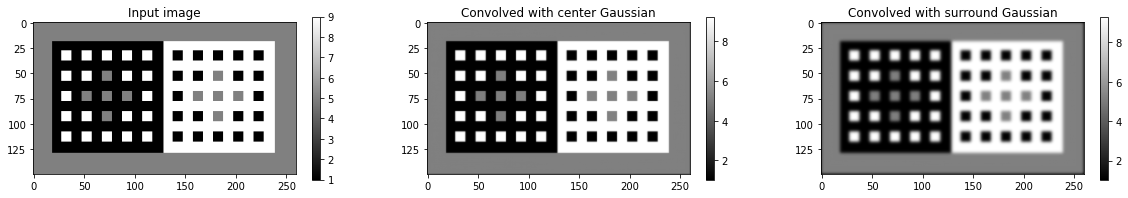

In [5]:
# Convolving input with Gaussians:
C_con = np.rot90(fftconvolve(np.rot90(input_image, 2), np.rot90(Gauss_con_c, 2), mode='same'), 2)
S_con = np.rot90(fftconvolve(np.rot90(input_image, 2), np.rot90(Gauss_con_s, 2), mode='same'), 2)

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title('Input image')
plt.colorbar()
plt.subplot(132)
plt.imshow(C_con, cmap='gray')
plt.title('Convolved with center Gaussian')
plt.colorbar()
plt.subplot(133)
plt.imshow(S_con, cmap='gray')
plt.title('Convolved with surround Gaussian')
plt.colorbar()
plt.show()

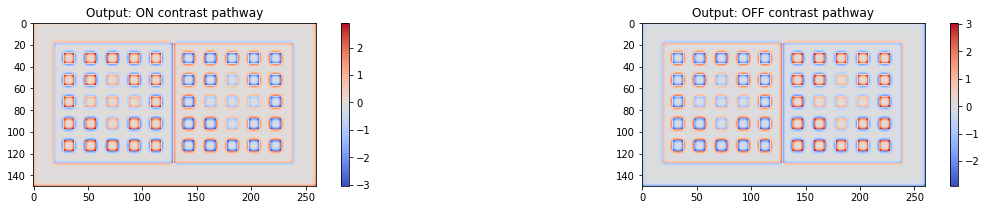

In [6]:
# Parameters for divisive inhibition:
alpha = 100.
beta = 100.
gamma = 100.

# Perform divisive inhibition
# ... for the ON pathway:
con_ON = (beta*C_con - gamma*S_con) / (alpha + C_con + S_con)
# ... for the OFF pathway:
con_OFF = (beta*S_con - gamma*C_con) / (alpha + C_con + S_con)

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(con_ON, cmap='coolwarm')
plt.title('Output: ON contrast pathway')
plt.colorbar()
plt.subplot(122)
plt.imshow(con_OFF, cmap='coolwarm')
plt.title('Output: OFF contrast pathway')
plt.colorbar()
plt.show()

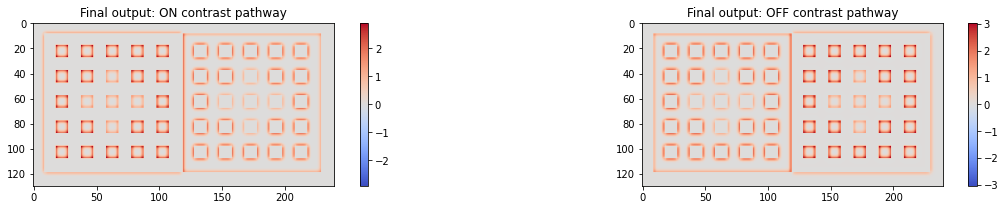

In [7]:
# Eliminate below threshold values (=negative values)
# ... for the ON pathway:
c_ON_full  = f_fun(con_ON)
# ... for the OFF pathway:
c_OFF_full = f_fun(con_OFF)

# Reduce output size to remove some gray background:
M, N = input_image.shape
Z = int(back_size/2)
c_ON  = c_ON_full[Z:M-Z, Z:N-Z]
c_OFF = c_OFF_full[Z:M-Z, Z:N-Z]

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(c_ON, cmap='coolwarm')
plt.title('Final output: ON contrast pathway')
plt.colorbar()
plt.clim(-c_ON.max(), c_ON.max())
plt.subplot(122)
plt.imshow(c_OFF, cmap='coolwarm')
plt.title('Final output: OFF contrast pathway')
plt.colorbar()
plt.clim(-c_OFF.max(), c_OFF.max())
plt.show()

### 2. The LUMINANCE pathways
Nodes in the ON Luminance Pathway encode input luminance, while nodes in the OFF Luminance Pathway encode its inverse.
This sensitivity to luminance is implemented by cells with UNBALANCED center-surround receptive fields in which the center outweighs the surround. Like this, these nodes approximate a luminance detector.

Justification for this model stage comes from the analysis of Mach bands, the Chevreul illusion and the perception of luminance gradients which can theoretically not be accounted for by the output from nodes with balanced receptive fields (Pessoa et al., 1995; Neumann, 1996; Todorovic, 2006).

The two Luminance Pathways will later provide complementary signals to the Filling-in Layer which would otherwise be lost in the Contrast Pathways.

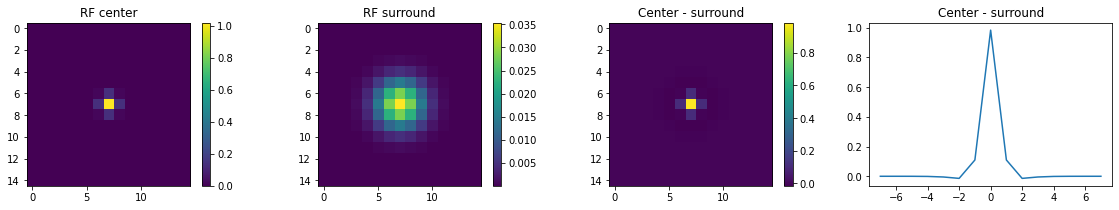

Sum of all kernel values:  1.146


In [8]:
# The RF will be modelled as a balanced difference-of-Gaussians
# filter:
# Parameters for the filter:
C2 = 1.6  # Peak response of the center Gaussian (Domijan: C2=1.6; Paper: C2=3.)
S2 = 0.5  # Peak response of the surround Gaussian (Domijan: S2=0.5; Paper: S2=1.)

# Create UNbalanced center and surround RFs:
Gauss_lum_c = C2 * np.exp(-(xx_retina**2 + yy_retina**2) / (2*Sigma_c**2)) / (2*np.pi*Sigma_c**2)
Gauss_lum_s = S2 * np.exp(-(xx_retina**2 + yy_retina**2) / (2*Sigma_s**2)) / (2*np.pi*Sigma_s**2)

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(141)
plt.imshow(Gauss_lum_c)
plt.title('RF center')
plt.colorbar()
plt.subplot(142)
plt.imshow(Gauss_lum_s)
plt.title('RF surround')
plt.colorbar()
plt.subplot(143)
plt.imshow(Gauss_lum_c - Gauss_lum_s)
plt.title('Center - surround')
plt.colorbar()
plt.subplot(144)
plt.plot(x_retina, (Gauss_lum_c - Gauss_lum_s)[int(RF_size/2),:])
plt.title('Center - surround')
plt.show()

# Summing the kernel up shows that it is "UNbalanced"
print('Sum of all kernel values: ', np.round((Gauss_lum_c - Gauss_lum_s).sum(), 3))

Next, we filter the input_image with these UNbalanced RFs (via convolution) and calculate the responses for the ON luminance pathway and OFF luminance pathway by performing a shunting / divisive inhibition.

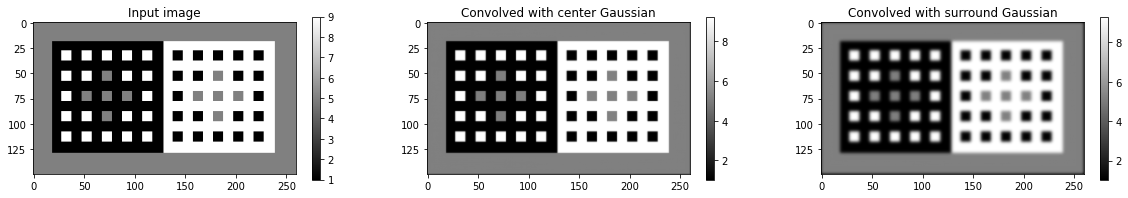

In [9]:
# Convolving input with RFs:
C_lum = np.rot90(fftconvolve(np.rot90(input_image, 2), np.rot90(Gauss_lum_c, 2), mode='same'), 2)
S_lum = np.rot90(fftconvolve(np.rot90(input_image, 2), np.rot90(Gauss_lum_s, 2), mode='same'), 2)

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title('Input image')
plt.colorbar()
plt.subplot(132)
plt.imshow(C_con, cmap='gray')
plt.title('Convolved with center Gaussian')
plt.colorbar()
plt.subplot(133)
plt.imshow(S_con, cmap='gray')
plt.title('Convolved with surround Gaussian')
plt.colorbar()
plt.show()

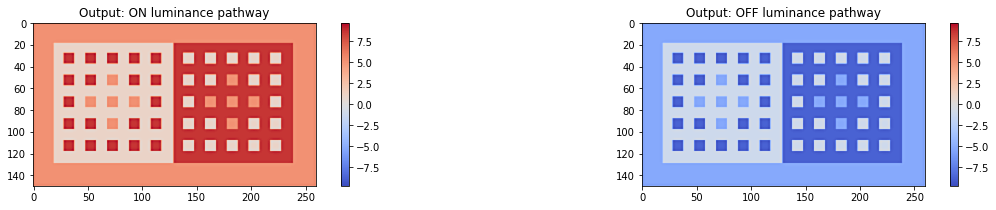

In [10]:
# Shunting / divisive inhibition
# ... for the ON pathway:
lum_ON = (beta*C_lum - gamma*S_lum) / (alpha + C_lum + S_lum)
# ... for the OFF pathway:
lum_OFF = (beta*S_lum - gamma*C_lum) / (alpha + C_lum + S_lum)

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(lum_ON, cmap='coolwarm')
plt.title('Output: ON luminance pathway')
plt.colorbar()
plt.clim(-lum_ON.max(), lum_ON.max())
plt.subplot(122)
plt.imshow(lum_OFF, cmap='coolwarm')
plt.title('Output: OFF luminance pathway')
plt.colorbar()
plt.clim(lum_OFF.min(), -lum_OFF.min())
plt.show()

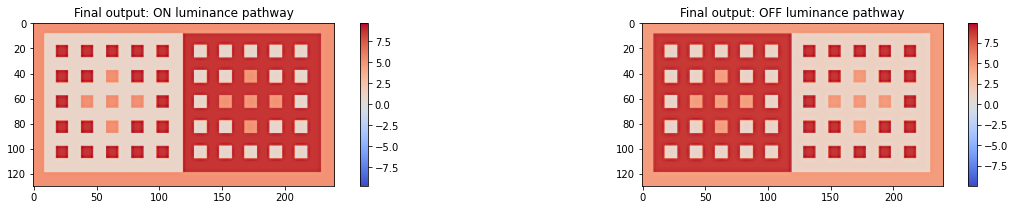

In [11]:
# Eliminate below threshold values (=negative values)
# ... for the ON pathway:
l_ON_full  = f_fun(lum_ON)
# ... for the OFF pathway:
# Important: the OFF Luminance activity is augmented by the tonic
# signal J which shifts the outputs above threshold:
J = 10.
l_OFF_full = f_fun(lum_OFF + J)

# Reduce output size to remove some gray background:
M, N = input_image.shape
Z = int(back_size/2)
l_ON  = l_ON_full[Z:M-Z, Z:N-Z]
l_OFF = l_OFF_full[Z:M-Z, Z:N-Z]

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(l_ON, cmap='coolwarm')
plt.title('Final output: ON luminance pathway')
plt.clim(-l_ON.max(), l_ON.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(l_OFF, cmap='coolwarm')
plt.title('Final output: OFF luminance pathway')
plt.clim(-l_OFF.max(), l_OFF.max())
plt.colorbar()
plt.show()

## The Boundary Contour System (BCS)

The BCS receives input from the ON and OFF Contrast Pathways.
In several processing steps, the BCS will extract orientation-sensitive information and integrate Local and Global Contour information into a final Edge Map that will be used in the Filling-in Layer.

In the following step, we will first compute the net difference by substracting the outputs of the ON and OFF Contrast Pathways from each other, since we will need this output for the following computations.

Side note: This output is equal to the ON and OFF Contrast Pathway signals before eliminating all below-threshold values. 

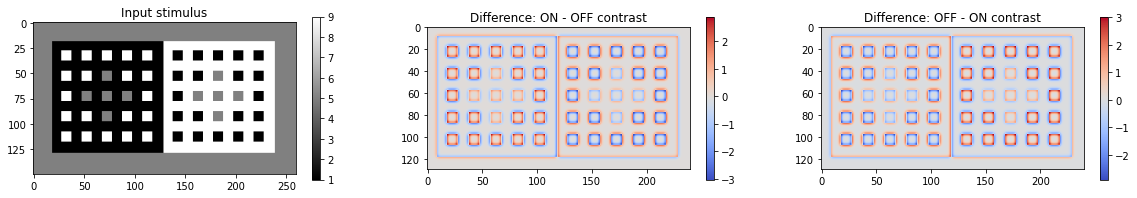

In [12]:
# The following computations will be based on the net difference
# between the outputs of the ON and OFF Contrast Pathways
ON = c_ON - c_OFF
OFF = c_OFF - c_ON

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title('Input stimulus')
plt.colorbar()
plt.subplot(132)
plt.imshow(ON, cmap='coolwarm')
plt.title('Difference: ON - OFF contrast')
plt.colorbar()
plt.subplot(133)
plt.imshow(OFF, cmap='coolwarm')
plt.title('Difference: OFF - ON contrast')
plt.colorbar()
plt.show()

### 1. Simple cells
The BCS simulates the orientation selectivity of Simple Cells in the primary visual cortex.
The RF of the simulated Simple Nodes consists of adjacent excitatory and inhibitory lobes elongated along the preferred orientation of the node.
This orientation-sensitivity is simulated by convolving an oriented Gabor filter with the output of the ON and OFF Contrast Pathways.
While being orientation-sensitive, Simple Nodes are also sensitive to contrast polarity.
Importantly, the model only takes Simple Nodes into account that prefer horizontal or vertical edges.


#### Tutorial example:
Before computing the Simple Cell outputs for all horizontal and vertical nodes, we will create one exemplary Simple Cell output by only using one vertical Gabor filter with a certain contrast polarity to illustrate this process in detail.

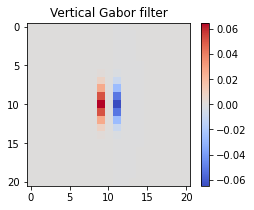

In [13]:
# Create vertical Gabor filter with certain contrast polarity:
gabor_size = 21
x_gabor = np.arange(-np.floor(gabor_size/2.), np.floor(gabor_size/2.)+1, 1)
xx_gabor, yy_gabor = np.meshgrid(x_gabor, x_gabor)

# Gabor orientation:
theta = np.pi / 2.
U = -xx_gabor*np.sin(theta) + yy_gabor*np.cos(theta)
W = xx_gabor*np.cos(theta) + yy_gabor*np.sin(theta)

Sigma_1 = 1.5  # Width of the filter in the preferred orientation
Sigma_2 = 0.5  # Width of the filter in the orthogonal orientation
G = 1.         # Constant that scales the Gabor amplitude
H = 0.5        # Controls the frequency of the filter's sinusoidal modulation

ex_Gabor = G * np.sin(H*U) * np.exp(-0.5 * ((W/Sigma_1)**2 + (U/Sigma_2)**2))

# Plotting:
plt.figure(figsize=(4,3))
plt.imshow(ex_Gabor, cmap='coolwarm')
plt.title('Vertical Gabor filter')
plt.colorbar()
plt.show()

As previously mentioned, the RF of the model Simple Node consists of adjacent excitatory and inhibitory lobes elongated along the preferred orientation of the node.
Now, the excitatory lobe receives excitatory projections from the ON Contrast Pathway and inhibitory projections from the OFF Contrast Pathway.
Respectively, the inhibitory lobe receives excitatory projections from the OFF Contrast Pathway and inhibitory projections from the ON Contrast Pathway.

We simulate this by convolving the difference between the output of the ON-OFF Contrast Pathways `ON` with the left (=positive) part of the Gabor `ex_Gaborp`.
Respectively, we convolve the net difference between the output of the OFF-ON Contrast Pathways `OFF` with the absolute of the right (="negative") part of the Gabor `ex_Gaborm`.

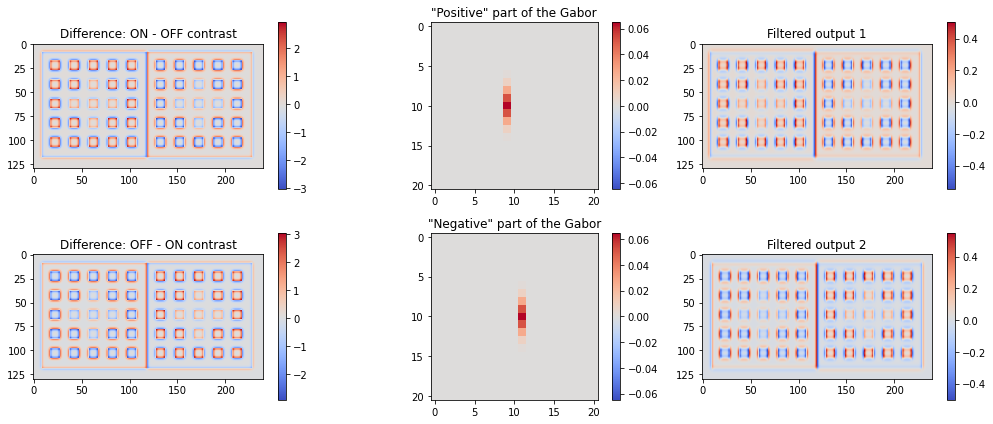

In [14]:
# Extract the left (=positive) side of the Gabor:
ex_Gaborp = f_fun(ex_Gabor)

# Extract the right (=negative) side of the Gabor,
# but transfer the negative into positive values:
ex_Gaborm = f_fun(-ex_Gabor)

# Convolve the net difference between the output of the ON-OFF contrast pathway
# with the left side of the Gabor:
ex_A_temp = np.rot90(fftconvolve(np.rot90(ON, 2), np.rot90(ex_Gaborp, 2), mode='same'), 2)

# Convolve the net difference between the output of the OFF-ON contrast pathway
# with the right side of the Gabor:
ex_B_temp = np.rot90(fftconvolve(np.rot90(OFF, 2), np.rot90(ex_Gaborm, 2), mode='same'), 2)

# Plotting:
plt.figure(figsize=(14, 6))
plt.subplot(231)
plt.imshow(ON, cmap='coolwarm')
plt.title('Difference: ON - OFF contrast')
plt.colorbar()
plt.subplot(232)
plt.imshow(ex_Gaborp, cmap='coolwarm')
plt.title('"Positive" part of the Gabor')
plt.clim(-ex_Gaborp.max(), ex_Gaborp.max())
plt.colorbar()
plt.subplot(233)
plt.imshow(ex_A_temp, cmap='coolwarm')
plt.title('Filtered output 1')
plt.colorbar()

plt.subplot(234)
plt.imshow(OFF, cmap='coolwarm')
plt.title('Difference: OFF - ON contrast')
plt.colorbar()
plt.subplot(235)
plt.imshow(ex_Gaborm, cmap='coolwarm')
plt.title('"Negative" part of the Gabor')
plt.clim(-ex_Gaborm.max(), ex_Gaborm.max())
plt.colorbar()
plt.subplot(236)
plt.imshow(ex_B_temp, cmap='coolwarm')
plt.title('Filtered output 2')
plt.colorbar()
plt.tight_layout()
plt.show()

In order to calculate the final Simple Cell output, we remove all negative values from these filtered outputs and combine them in the following equation:

$X = f [A + B - |A - B| - T]$,
where $A$ and $B$ are the filtered outputs, $f$ removes all negative values and $T$ is a threshold that removes weak and noisy boundary responses.

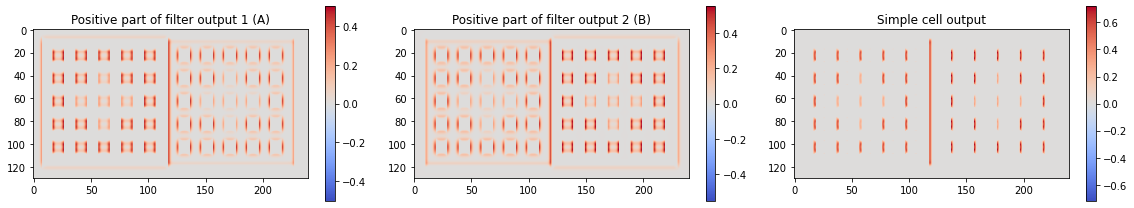

In [15]:
# Eliminate all negative values
ex_A = f_fun(ex_A_temp)
ex_B = f_fun(ex_B_temp)

# Calculate simple cell response:
T_1 = 0.05     # Threshold that removes weak and noisy boundary responses
ex_x_1 = f_fun((ex_A+ex_B) - np.abs(ex_A-ex_B) - T_1)

# Plotting:
plt.figure(figsize=(16, 3))
plt.subplot(131)
plt.imshow(ex_A, cmap='coolwarm')
plt.title('Positive part of filter output 1 (A)')
plt.clim(-ex_A.max(), ex_A.max())
plt.colorbar()
plt.subplot(132)
plt.imshow(ex_B, cmap='coolwarm')
plt.title('Positive part of filter output 2 (B)')
plt.clim(-ex_B.max(), ex_B.max())
plt.colorbar()
plt.subplot(133)
plt.imshow(ex_x_1, cmap='coolwarm')
plt.title('Simple cell output')
plt.clim(-ex_x_1.max(), ex_x_1.max())
plt.colorbar()
plt.tight_layout()
plt.show()

#### Full code:
In the full code, we repeat the same procedure as demonstrated in the **Tutorial example** but using both horizontal and vertical Gabor filters with both polarities.
We will visualize the final Simple Cells outputs in the following plot.

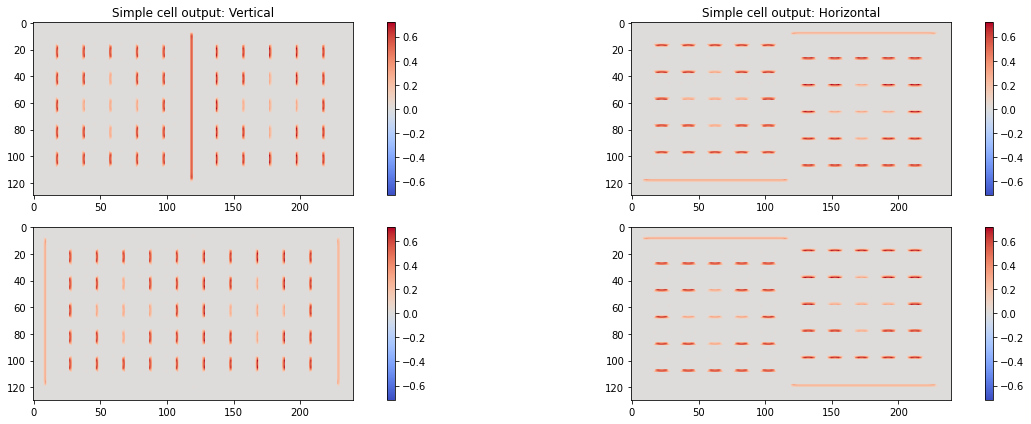

In [16]:
# Parameters:
M_out, N_out = ON.shape
K = 12         # Total number of orientations
Sigma_1 = 1.5  # Width of the filter in the preferred orientation
Sigma_2 = 0.5  # Width of the filter in the orthogonal orientation
G = 1.         # Constant that scales the Gabor amplitude
H = 0.5        # Controls the frequency of the filter's sinusoidal modulation
T_1 = 0.05     # Threshold that removes weak and noisy boundary responses (simple cell)

# Prepare Gabors:
gabor_size = 21
rec = np.floor(gabor_size/2.)
x_gabor = np.arange(-rec, rec+1, 1)
xx_gabor, yy_gabor = np.meshgrid(x_gabor, x_gabor)

# Initiate output variable for simple cells with K orientations:
simple_out = np.zeros([M_out, N_out, K])

# Create output of simple cortical cells:
# For simplicity, only horizontal (k=3) and vertical (k=6) orientations
# were used here:
for k in range(3, K+1, 3):
    theta = (2.*np.pi*float(k)) / float(K)
    U = -xx_gabor*np.sin(theta) + yy_gabor*np.cos(theta)
    W = xx_gabor*np.cos(theta) + yy_gabor*np.sin(theta)

    # Calculate Gabors
    Gabor = G * np.sin(H*U) * np.exp(-0.5 * ((W/Sigma_1)**2 + (U/Sigma_2)**2))
    Gaborp = f_fun(Gabor)
    Gaborm = f_fun(-Gabor)

    # The simple node is sensitive to contrast polarity thus it has two
    # lobes with opposite polarities (here: A and B)
    A_temp = np.rot90(fftconvolve(np.rot90(ON, 2), np.rot90(Gaborp, 2), mode='same'), 2)
    A = f_fun(A_temp)
    B_temp = np.rot90(fftconvolve(np.rot90(OFF, 2), np.rot90(Gaborm, 2), mode='same'), 2)
    B = f_fun(B_temp)

    # Simple cell output:
    simple_out[:,:,k-1] = f_fun((A+B) - np.abs(A-B) - T_1)


# Visalize simple cell output:
plt.figure(figsize=(18, 6))
plt.subplot(221)
plt.imshow(simple_out[:,:,2], cmap='coolwarm')
plt.title('Simple cell output: Vertical')
plt.clim(-simple_out[:,:,2].max(), simple_out[:,:,2].max())
plt.colorbar()
plt.subplot(223)
plt.imshow(simple_out[:,:,8], cmap='coolwarm')
plt.clim(-simple_out[:,:,8].max(), simple_out[:,:,8].max())
plt.colorbar()
plt.subplot(222)
plt.imshow(simple_out[:,:,5], cmap='coolwarm')
plt.title('Simple cell output: Horizontal')
plt.clim(-simple_out[:,:,5].max(), simple_out[:,:,5].max())
plt.colorbar()
plt.subplot(224)
plt.imshow(simple_out[:,:,11], cmap='coolwarm')
plt.clim(-simple_out[:,:,11].max(), simple_out[:,:,11].max())
plt.colorbar()
plt.tight_layout()
plt.show()

### 2. Complex cell
The RF of the simulated Complex Nodes is created by summing the output from the pair of like-oriented Simple Nodes with the output of the Simple Nodes that have opposite contrast polarities.
Consequently, the Complex Cells lose their sensitivity to contrast polarity.

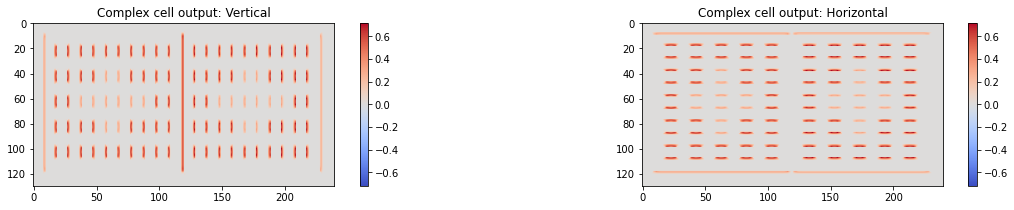

In [17]:
# Initiate output variable for simple cells with K orientations:
complex_out = np.zeros([M_out, N_out, int(K/2)])

# Create output of complex cortical cells by adding up simple
# cell outputs with opposite contrast polarities:
for i in range(int(K/2)):
    complex_out[:,:,i] = simple_out[:,:,i] + simple_out[:,:,i+6]

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(complex_out[:,:,2], cmap='coolwarm')
plt.title('Complex cell output: Vertical')
plt.clim(-complex_out[:,:,5].max(), complex_out[:,:,5].max())
plt.colorbar()
plt.subplot(122)
plt.imshow(complex_out[:,:,5], cmap='coolwarm')
plt.title('Complex cell output: Horizontal')
plt.clim(-complex_out[:,:,5].max(), complex_out[:,:,5].max())
plt.colorbar()
plt.show()

### 3. Local Boundary Detection (LBD)
Next, we will use the output of the Complex Nodes in order to compute the Local Boundary signal.

A long recognized problem for filling-in models is that the response of Simple and Complex Nodes is weakened at corners (Gove, Grossberg, & Mingolla, 1995; Grossberg, 2003).
There are different solutions to this problem with varying complexities.
In this paper, a simple solution is offered that introduces the feedforward computation of the so-called MAX function in the complex cells.
The basic idea of this MAX function is that we will update each individual node (=pixel) that has an activation larger than zero by the maximum activity value in it's close surround.

For this, let's prepare all relevant variables needed to compute the MAX function in the next step including a binarized "mask" to prevent activity spreading to nodes that have zero activation.

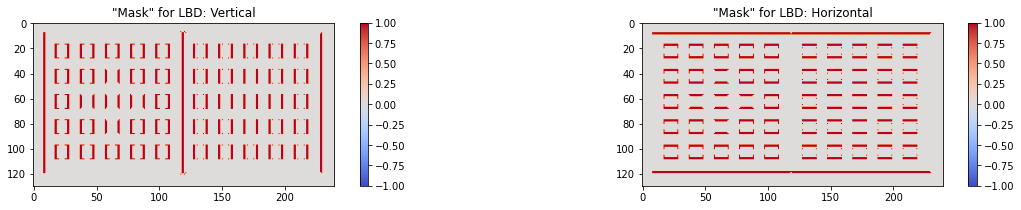

In [18]:
# Parameters
L = 4    # Influences range of "horizontal connections" (Drazen: L=4, Paper: not given)
P = 15   # Elongation of the extra-classical RF in preferred orientation (Drazen: P=15, Paper: P=10)
Q = 5    # Elongation of the extra-classical RF in orthogonal orientation (Drazen: Q=5, Paper: Q=4)

M, N = c_ON.shape

# Prepare computation of MAX function: vertical outputs
LBD_v = np.zeros([M+2*P, N+2*P])
LBD_v[P:M+P, P:N+P] = complex_out[:,:,2]
temp_v = LBD_v
LBD_mask_v = h_fun(LBD_v)

# Prepare computation of MAX function: horizontal outputs
LBD_h = np.zeros([M+2*P, N+2*P])
LBD_h[P:M+P, P:N+P] = complex_out[:,:,5]
temp_h = LBD_h
LBD_mask_h = h_fun(LBD_h)


# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(LBD_mask_v[P:M+P, P:N+P], cmap='coolwarm')
plt.title('"Mask" for LBD: Vertical')
plt.clim(-LBD_mask_v.max(), LBD_mask_v.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(LBD_mask_h[P:M+P, P:N+P], cmap='coolwarm')
plt.title('"Mask" for LBD: Horizontal')
plt.clim(-LBD_mask_h.max(), LBD_mask_h.max())
plt.colorbar()
plt.show()

Now, the Complex Nodes compute the feedforward MAX function among its `L` nearest neighbors by updating each  node (=pixel) by the maximum value in it's close surround.
Like this, more uniform Local Boundary representations are achieved without an attenuation at corners and junctions.

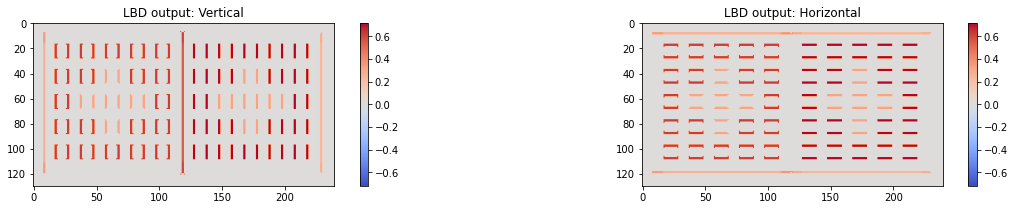

In [19]:
# Compute MAX function among L nearest neighbors for LBD:
# ... for vertical outputs:
LBD_v_temp = LBD_v
# Update each pixel by the max in it's surround:
LBD_v_temp[0:M+L+L+1, L-1:N+L+2] = ndimage.maximum_filter(temp_v[0:M+L+L+1, L-1:N+L+2], size=(L*2+1, 3))
# Multiply this output with the mask to prevent activity spreading to non-active nodes:
LBD_v = LBD_mask_v * LBD_v_temp

# ... for horizontal outputs:
LBD_h_temp = LBD_h
# Update each pixel by the max in it's surround:
LBD_h_temp[L-1:M+L+2, 0:N+L+L+1] = ndimage.maximum_filter(temp_h[L-1:M+L+2, 0:N+L+L+1], size=(3, L*2+1))
# Multiply this output with the mask to prevent activity spreading to non-active nodes:
LBD_h = LBD_mask_h * LBD_h_temp


# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.imshow(LBD_v[P:M+P, P:N+P], cmap='coolwarm')
plt.title('LBD output: Vertical')
plt.clim(-LBD_v.max(), LBD_v.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(LBD_h[P:M+P, P:N+P], cmap='coolwarm')
plt.title('LBD output: Horizontal')
plt.clim(-LBD_h.max(), LBD_h.max())
plt.colorbar()
plt.show()

### 4. Global boundary detection (GBD)
In the next step, we will use the Local Boundary signal in order to compute the Global Boundary signal.
The goal of this stage is to detect the presence of strong boundary signals that are collinear to
or parallel with the weaker boundary signal in the node's receptive field.
Importantly, responses to low-contrast contours will get enhanced in the presence of collinear or parallel high-contrast contours in the surround (= contour facilitation).
This idea is implemented by computing the MAX function again - but this time recursively with a larger window until a steady state is reached.

In order to do so, let's prepare all relevant variables in order to compute the MAX function recurrently for GBD.

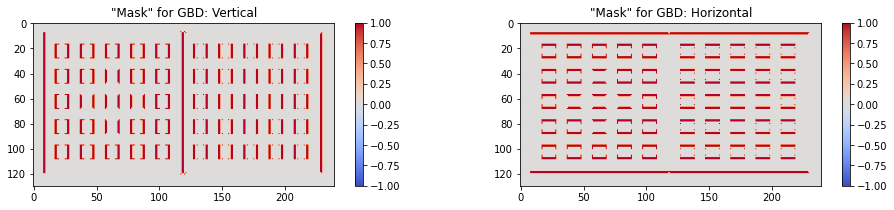

In [20]:
# Prepare variables for MAX function: vertical outputs
temp2_v = LBD_v
GBD_v = copy.deepcopy(LBD_v)
GBD_v_temp = GBD_v
GBD_mask_v = h_fun(LBD_v)

# Prepare variables for MAX function: horizontal outputs
temp2_h = LBD_h
GBD_h = copy.deepcopy(LBD_h)
GBD_h_temp = GBD_h
GBD_mask_h = h_fun(LBD_h)

# Plotting:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.imshow(GBD_mask_v[P:M+P, P:N+P], cmap='coolwarm')
plt.title('"Mask" for GBD: Vertical')
plt.clim(-GBD_mask_v.max(), GBD_mask_v.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(GBD_mask_h[P:M+P, P:N+P], cmap='coolwarm')
plt.title('"Mask" for GBD: Horizontal')
plt.clim(-GBD_mask_h.max(), GBD_mask_h.max())
plt.colorbar()
plt.show()

Instead of only computing the MAX function once within a rather narrow window for LBD, the nodes for GBD employ the recurrent computation of the MAX function with an elongated window until a steady state is reached.
Like this, GBD nodes are sensitive to high-contrast boundary signals in their extra-classical RF.
The elongation of these extra-classical RFs in the preferred orientation and orthogonal to the preferred orientation are specified by the parameters `P` and `Q`.
In all the simulations in the paper, it was sufficient to apply 20 recurrent steps in order to reach a steady
state.

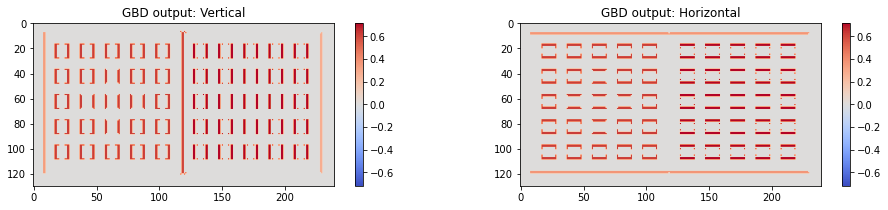

In [21]:
GBD_steps = 20

# Recurrent computation of max function for GBD:
for t in range(GBD_steps):
    # ... for vertical outputs
    GBD_v_temp[0:M+P+P+1, P-Q:N+P+Q+1] = ndimage.maximum_filter(temp2_v[0:M+P+P+1, P-Q:N+P+Q+1], size=(P*2+1, Q*2+1))
    GBD_v = GBD_mask_v * GBD_v_temp
    temp2_v = GBD_v
    
    # ... for horizontal outputs
    GBD_h_temp[P-Q:M+P+Q+1, 0:N+P+P+1] = ndimage.maximum_filter(temp2_h[P-Q:M+P+Q+1, 0:N+P+P+1], size=(Q*2+1, P*2+1))
    GBD_h = GBD_mask_h * GBD_h_temp
    temp2_h = GBD_h


# Plotting:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.imshow(GBD_v[P:M+P, P:N+P], cmap='coolwarm')
plt.title('GBD output: Vertical')
plt.clim(-GBD_v.max(), GBD_v.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(GBD_h[P:M+P, P:N+P], cmap='coolwarm')
plt.title('GBD output: Horizontal')
plt.clim(-GBD_h.max(), GBD_h.max())
plt.colorbar()
plt.show()

### 5. Interactions between LBD and GBD
In order to get an idea about which contours were facilitated during the Global Boundary processing step, let's visualize the difference between the Local Boundary signal and the Global Boundary signal:

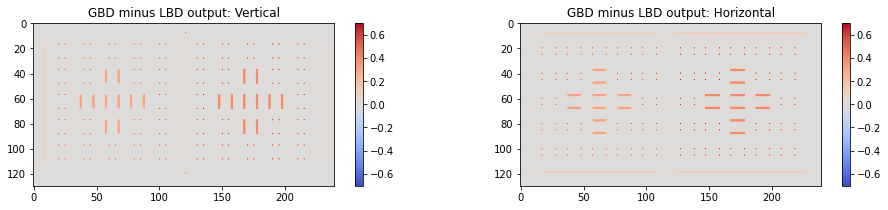

In [22]:
diff_v = GBD_v - LBD_v
diff_h = GBD_h - LBD_h

# Plotting:
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.imshow(diff_v[P:M+P, P:N+P], cmap='coolwarm')
plt.title('GBD minus LBD output: Vertical')
plt.clim(-diff_v.max(), diff_v.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(diff_h[P:M+P, P:N+P], cmap='coolwarm')
plt.title('GBD minus LBD output: Horizontal')
plt.clim(-diff_h.max(), diff_h.max())
plt.colorbar()
plt.show()

The final output of the BCS is obtained by computing the interaction between the output of the Local and Global Boundary Detection.
When the Local and Global Boundary signals are of equal strength, their ratio will be close to 1.
This is the case when there is no collinear or parallel contour facilitation among the GBD nodes.
On the other hand, when the GBD signal is much larger relative to the LBD, their ratio will be 0.

The output of the L/G Interaction stage is binary.
It will assume value 1 if the computed ratio crosses the threshold, and value 0 if the ratio is smaller than the threshold.
The threshold is set in a way to favor larger ratios (i.e., ratios closer to 1).
In this way, Boundary Contour representation of the low-contrast edge that is collinear or parallel with high-contrast edge will be removed from the BCS output (= contour suppression).
On the other hand, Boundary Contour representation of the low-contrast edge that is not collinear or parallel with high-contrast edge will remain intact in the BCS output

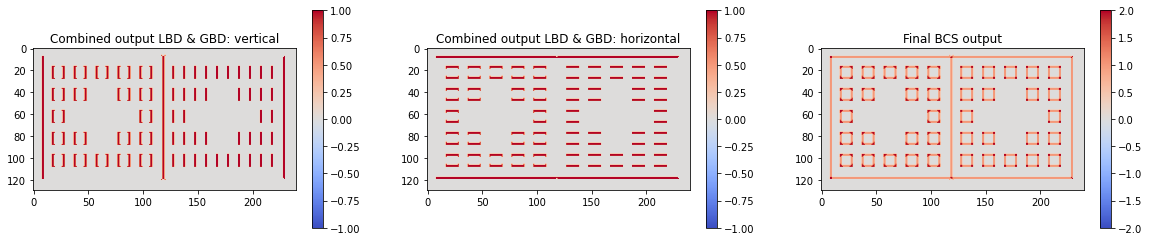

In [23]:
# Parameters
T_r = 0.6  # Suppresses L/G Interaction output where their ratio is less than 1
F = 0.01   # Controls the precision of the ratio computation

# Combine and binarize LBD and GBD outputs:
R_v = h_fun( (LBD_v / (F+GBD_v)) - T_r)
R_h = h_fun( (LBD_h / (F+GBD_h)) - T_r)

# Add vertical and horizontal component:
R_full = R_h + R_v

# Reduce output size to remove some background:
R = R_full[P:M_out+P, P:N_out+P]

# Plotting:
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.imshow(R_v[P:M+P, P:N+P], cmap='coolwarm')
plt.title('Combined output LBD & GBD: vertical')
plt.clim(-R_v.max(), R_v.max())
plt.colorbar()
plt.subplot(132)
plt.imshow(R_h[P:M+P, P:N+P], cmap='coolwarm')
plt.title('Combined output LBD & GBD: horizontal')
plt.clim(-R_h.max(), R_h.max())
plt.colorbar()
plt.subplot(133)
plt.imshow(R, cmap='coolwarm')
plt.title('Final BCS output')
plt.clim(-R.max(), R.max())
plt.colorbar()
plt.show()

## The Feature Contour System (FCS)

### 1. Integrating CONTRAST and LUMINANCE pathways
The outputs from the Contrast and Luminance Pathways are combined separately for the ON and OFF pathways in order to provide Feature Contour signals for the ON and OFF Filling-in Layers respectively.

Weights `w1` and `w2` scale the relative contribution of the Contrast and Luminance signals in generating brightness percepts.
Higher values of `w1` give rise to a tendency towards brightness induction while higher values of `w2` give rise to a tendency towards brightness assimilation.

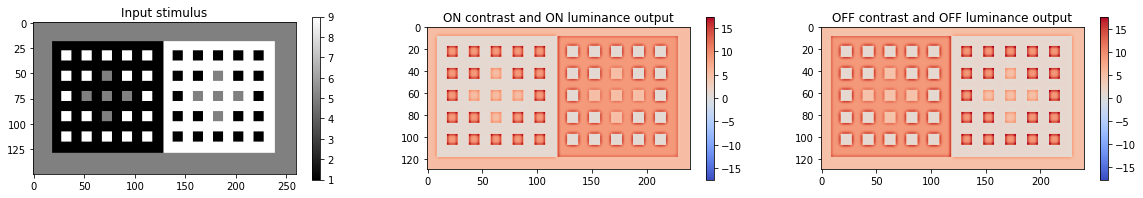

In [24]:
# Parameters for integration:
w1 = 3.
w2 = 1.

# Contrast and luminance intgration in the ON channels:
m_ON  = w1*c_ON  + w2*l_ON

# Contrast and luminance intgration in the OFF channels:
m_OFF = w1*c_OFF + w2*l_OFF

# Plotting:
plt.figure(figsize=(20, 3))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title('Input stimulus')
plt.colorbar()
plt.subplot(132)
plt.imshow(m_ON, cmap='coolwarm')
plt.title('ON contrast and ON luminance output')
plt.clim(-m_ON.max(), m_ON.max())
plt.colorbar()
plt.subplot(133)
plt.imshow(m_OFF, cmap='coolwarm')
plt.title('OFF contrast and OFF luminance output')
plt.clim(-m_OFF.max(), m_OFF.max())
plt.colorbar()
plt.show()

### 2. ON and OFF Filling-in Layers
Finally, we have computed all the signals that we need in order to perform filling-in.
These signals include the Edge Map `R` given by the BCS as well as the Contrast and Luminance signals provided by the ON & OFF Contrast and Luminance Pathways `m_ON` and `m_OFF`.

Based on these inputs, we will prepare and visualize all variables that we will need in order to perform filling-in in the next step.
These variables include:
* the thresholded Contrast and Luminance Signals which will serve as initial states for the filling-in process (`M_ON` and `M_OFF`),
* two binary masks that prevent activity spreading to non-active units (`mask_ON` and `mask_OFF`),
* the Edge Map from the BCS that prevents activity spreading across contours (`R` or `edge`),
* some additional variables that help to implement filling-in efficiently (not visualized)

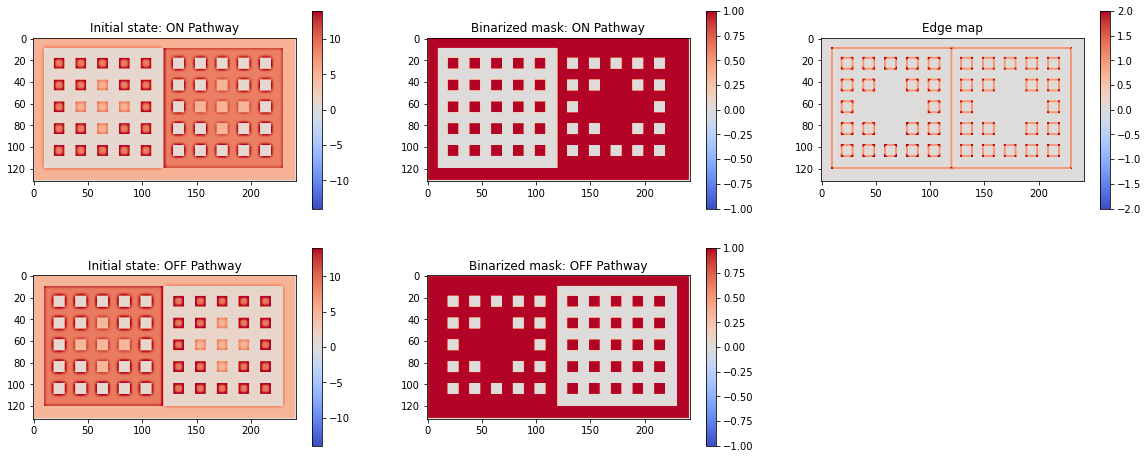

In [25]:
epsilon = 10. # Controls the strength of divisive inhibition
T_f = 3.      # Prevents filling-in for weak luminance and contrast signals

# Initiate all relevant variables:
# NOTE: We initiate all variable slightly larger than
# before in order to efficiently compute the MAX function

# Edge map from BCS that prevents acitivity spreading across edges:
edge = np.zeros([M+2,N+2])
edge[1:M+1, 1:N+1] = R

# Threshold outputs from the ON and OFF Contrast and Luminance Pathways
# for filling-in:
M_ON = np.zeros([M+2,N+2])
M_ON[1:M+1, 1:N+1] = s_fun(14., m_ON)
M_ON_temp = copy.deepcopy(M_ON)

M_OFF = np.zeros([M+2,N+2])
M_OFF[1:M+1, 1:N+1] = s_fun(14., m_OFF)
M_OFF_temp = copy.deepcopy(M_OFF)

# Binarize outputs from the ON and OFF Contrast and Luminance Pathways
# in order to prevent spreading to non-active units:
mask_ON = np.zeros([M+2,N+2])
mask_ON[1:M+1, 1:N+1]  = h_fun(m_ON - T_f)

mask_OFF = np.zeros([M+2,N+2])
mask_OFF[1:M+1, 1:N+1] = h_fun(m_OFF - T_f)

# Some variables to efficiently compute the MAX function between
# neighboring pixels:
top_ON = np.zeros([M+2,N+2])
bottom_ON = np.zeros([M+2,N+2])
left_ON = np.zeros([M+2,N+2])
right_ON = np.zeros([M+2,N+2])

top_OFF = np.zeros([M+2,N+2])
bottom_OFF = np.zeros([M+2,N+2])
left_OFF = np.zeros([M+2,N+2])
right_OFF = np.zeros([M+2,N+2])


# Plotting:
plt.figure(figsize=(20, 8))
plt.subplot(233)
plt.imshow(edge, cmap='coolwarm')
plt.title('Edge map')
plt.clim(-edge.max(), edge.max())
plt.colorbar()
plt.subplot(231)
plt.imshow(M_ON, cmap='coolwarm')
plt.title('Initial state: ON Pathway')
plt.clim(-M_ON.max(), M_ON.max())
plt.colorbar()
plt.subplot(234)
plt.imshow(M_OFF, cmap='coolwarm')
plt.title('Initial state: OFF Pathway')
plt.clim(-M_OFF.max(), M_OFF.max())
plt.colorbar()
plt.subplot(232)
plt.imshow(mask_ON, cmap='coolwarm')
plt.title('Binarized mask: ON Pathway')
plt.clim(-mask_ON.max(), mask_ON.max())
plt.colorbar()
plt.subplot(235)
plt.imshow(mask_OFF, cmap='coolwarm')
plt.title('Binarized mask: OFF Pathway')
plt.clim(-mask_OFF.max(), mask_OFF.max())
plt.colorbar()
plt.show()

Filling-in is implemented separately for the ON Pathway and for the OFF Pathway.
The input to the ON Filling-in Layer is given by the ON Contrast and Luminance Pathways, and the input to the OFF Filling-in Layer is given by the OFF Contrast and Luminance Pathways.

In both cases, filling-in is implemented by recurrently applying the MAX function among the direct nearest neighbors.
These neighbors include one pixel above (`top_ON` and `top_OFF`), below (`bottom_ON` and `bottom_OFF`), left (`left_ON` and `left_OFF`) and right (`right_ON` and `right_OFF`).

Like this, the activity spreading follows three "rules":
1. Activity in the Contrast and Luminance Signals spreads from highly active units to less active units (`M_ON` and `M_OFF`).
2. Activity does not spread to units that are not active. Computationally, we control for this with the binary masks (`mask_ON` and `mask_OFF`)
3. Activity does not spread over borders. Computationally, we control for this by "penalizing" the activity at an edges.

In the simulations presented here, it was sufficient to apply 300 time steps in order to reach steady state.
For visualization purposes, we demonstrate the full filling-in process in the following video.

In [26]:
# In order to visualize the filling-in process over time:
fill_steps = 300  # (Domijan: 300, Paper: 200)
M_ON_vid = np.zeros([M+2,N+2, fill_steps])
M_OFF_vid = np.zeros([M+2,N+2, fill_steps])

# Compute the recurrent MAX function among the nearest neighbors
# (one pixel up, down, left, right)
for t in range(fill_steps):
    # Select the nearest neighbors (top, bottom, left, right)
    # IMPORTANT: Activity at borders is "penalized" / strongly reduced
    top_ON[1:M+1, 1:N+1]    = M_ON[0:M,   1:N+1] / (1+epsilon*edge[0:M,   1:N+1] *edge[1:M+1, 1:N+1])
    bottom_ON[1:M+1, 1:N+1] = M_ON[2:M+2, 1:N+1] / (1+epsilon*edge[2:M+2, 1:N+1] *edge[1:M+1, 1:N+1])
    left_ON[1:M+1, 1:N+1]   = M_ON[1:M+1, 0:N]   / (1+epsilon*edge[1:M+1, 0:N]   *edge[1:M+1, 1:N+1])
    right_ON[1:M+1, 1:N+1]  = M_ON[1:M+1, 2:N+2] / (1+epsilon*edge[1:M+1, 2:N+2] *edge[1:M+1, 1:N+1])
    
    # Select the nearest neighbors (top, bottom, left, right)
    # IMPORTANT: Activity at borders is "penalized" / strongly reduced
    top_OFF[1:M+1, 1:N+1]    = M_OFF[0:M,   1:N+1] / (1+epsilon*edge[0:M,   1:N+1] *edge[1:M+1, 1:N+1])
    bottom_OFF[1:M+1, 1:N+1] = M_OFF[2:M+2, 1:N+1] / (1+epsilon*edge[2:M+2, 1:N+1] *edge[1:M+1, 1:N+1])
    left_OFF[1:M+1, 1:N+1]   = M_OFF[1:M+1, 0:N]   / (1+epsilon*edge[1:M+1, 0:N]   *edge[1:M+1, 1:N+1])
    right_OFF[1:M+1, 1:N+1]  = M_OFF[1:M+1, 2:N+2] / (1+epsilon*edge[1:M+1, 2:N+2] *edge[1:M+1, 1:N+1])
    
    # Select the MAX value between top_ON, bottom_ON, left_ON, right_ON:
    M_ON_temp[1:M+1, 1:N+1] = np.maximum(top_ON[1:M+1, 1:N+1], bottom_ON[1:M+1, 1:N+1])
    M_ON_temp[1:M+1, 1:N+1] = np.maximum(M_ON_temp[1:M+1, 1:N+1], left_ON[1:M+1, 1:N+1])
    M_ON_temp[1:M+1, 1:N+1] = np.maximum(M_ON_temp[1:M+1, 1:N+1], right_ON[1:M+1, 1:N+1])
    
    # Select the MAX value between top_OFF, bottom_OFF, left_OFF, right_OFF:
    M_OFF_temp[1:M+1, 1:N+1] = np.maximum(top_OFF[1:M+1, 1:N+1], bottom_OFF[1:M+1, 1:N+1])
    M_OFF_temp[1:M+1, 1:N+1] = np.maximum(M_OFF_temp[1:M+1, 1:N+1], left_OFF[1:M+1, 1:N+1])
    M_OFF_temp[1:M+1, 1:N+1] = np.maximum(M_OFF_temp[1:M+1, 1:N+1], right_OFF[1:M+1, 1:N+1])
    
    M_ON = np.maximum(M_ON, (mask_ON * M_ON_temp))
    M_OFF = np.maximum(M_OFF, (mask_OFF * M_OFF_temp))
    
    M_ON_vid[:,:,t] = M_ON
    M_OFF_vid[:,:,t] = M_OFF


In [27]:
# Save first 50 frames of filling-in videos
save_video(M_ON_vid[:,:,0:50], M_OFF_vid[:,:,0:50], 'images/filling_in_jn', fill_steps)

In [28]:
# Plot videos as gif:
HTML('<img src="images/filling_in_jn.gif">')

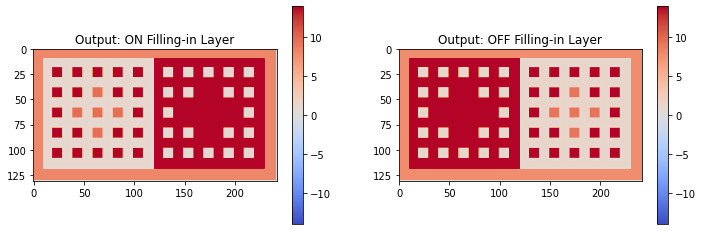

In [29]:
# Plot outputs of Filling-in Layer:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(M_ON, cmap='coolwarm')
plt.title('Output: ON Filling-in Layer')
plt.clim(-M_ON.max(), M_ON.max())
plt.colorbar()
plt.subplot(122)
plt.imshow(M_OFF, cmap='coolwarm')
plt.title('Output: OFF Filling-in Layer')
plt.clim(-M_OFF.max(), M_OFF.max())
plt.colorbar()
plt.show()

### 2. Predicted brightness
Final model's prediction of the brightness percept is obtained by thresholding and subtracting the output of the OFF Filling-in Layer from the output of the ON Filling-in Layer.
This value is normalized and qualitatively compared to human perception.

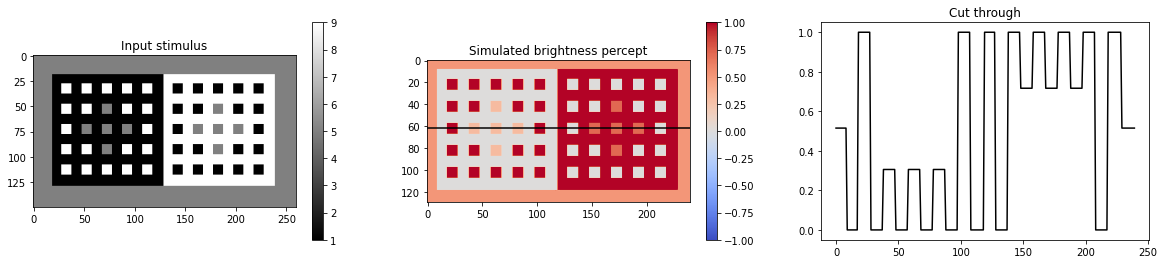

In [32]:
# Calculate brightness percept:
bright_raw = f_fun( M_ON[1:M+1, 1:N+1] - T_f) - f_fun( M_OFF[1:M+1, 1:N+1] - T_f)

# Normalization:
bright_raw = bright_raw + np.abs(bright_raw.min())
bright = bright_raw / bright_raw.max()

# Plotting:
cut_height = 62

plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title('Input stimulus')
plt.colorbar()
plt.subplot(132)
plt.imshow(bright, cmap='coolwarm')
plt.axhline(y=cut_height,color='k')
plt.title('Simulated brightness percept')
plt.colorbar()
plt.clim(-bright.max(), bright.max())
plt.subplot(133)
x_ax = np.arange(0, np.size(bright, 1))
plt.plot(x_ax, np.squeeze(bright[cut_height, :]), 'k')
plt.title('Cut through')
plt.show()


## Remarks from the paper
Although the proposed neural architecture has many degrees of freedom, there are several parameters critical for the model's success such as the threshold for activation of the Filling-in Layers `T_f`, the threshold for the L/G Interaction `T_r`, and weights `w1` and `w2` for the Contrast and Luminance Pathways.
However, small variations in the size of these parameters (up to 20% of the chosen value) do not produce qualitative change in the model's behavior (with exception of the checkerboard contrast).

The parameters for the Local Boundary Detection were chosen in a way to achieve sharp Boundary Contour representation, but even if the LBD response is blurry, the model would achieve contour facilitation in the GBD and a reduction of the Boundary Contour representation in the L/G Interaction.
Finally, it should be emphasized that all simulation results presented in the paper are produced with the same set of parameters.